# Importar Librarias y datos

In [194]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np   
import itertools

from scipy.stats import chi2_contingency, ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf 

In [195]:
df = pd.read_parquet("output_08.parquet")

In [196]:
df.head()

,age,stocks_status,gains,education_secondary_complete,education_secondary_incomplete,education_technical_education/university_incomplete,education_university_graduate_or_higher,country_of_birth_own_US,is_hispanic_Otro,race_Otro,race_White,citizenship_Native,citizenship_Otro,gender_1.0,income_above_limit_1.0
0,0.853333,0.00292,0.0,True,False,False,False,True,False,False,True,True,False,True,False
1,0.666667,0.00000,0.0,True,False,False,False,True,False,False,True,True,False,True,False
2,0.080000,0.00000,0.0,False,True,False,False,True,False,False,False,True,False,False,False
4,0.733333,0.00000,0.0,True,False,False,False,True,False,False,True,True,False,False,False
5,0.400000,0.00000,0.0,False,False,False,True,False,False,True,False,False,False,False,False


# Modelo Maching Learning Regresion Logistica 

In [198]:
df.shape

(159814, 15)

In [199]:
df.columns.values

array(['age', 'stocks_status', 'gains', 'education_secondary_complete',
       'education_secondary_incomplete',
       'education_technical_education/university_incomplete',
       'education_university_graduate_or_higher',
       'country_of_birth_own_US', 'is_hispanic_Otro', 'race_Otro',
       'race_White', 'citizenship_Native', 'citizenship_Otro',
       'gender_1.0', 'income_above_limit_1.0'], dtype=object)

### Under Sampling

In [201]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [202]:

X = df.drop(columns=['income_above_limit_1.0']) # rm edit
y = df['income_above_limit_1.0'] # rm edit
print(y.value_counts())

income_above_limit_1.0
False    146816
True      12998
Name: count, dtype: int64


In [203]:

X_resampled, y_resampled = RandomUnderSampler().fit_resample(X, y)


model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)

importances = model.feature_importances_
feature_names = X.columns

sorted_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
print(sorted_features)

[('age', 0.3064069361781989), ('stocks_status', 0.19303856964011581), ('education_university_graduate_or_higher', 0.14425987063171317), ('gender_1.0', 0.1263374895735699), ('gains', 0.0951511703943263), ('education_secondary_incomplete', 0.05245104920218293), ('education_secondary_complete', 0.026010055287455695), ('education_technical_education/university_incomplete', 0.01620063325575878), ('is_hispanic_Otro', 0.013242040390214314), ('race_White', 0.00997651812354847), ('citizenship_Otro', 0.005424116065913007), ('race_Otro', 0.004634628328862675), ('country_of_birth_own_US', 0.0034690379081355693), ('citizenship_Native', 0.003397885020004627)]


In [204]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)  # Apply scaling


### Elegir las columnas 

In [206]:
rfe = RFE(estimator=LogisticRegression(max_iter=500), n_features_to_select=7)
rfe.fit(X_resampled, y_resampled)

selected_features = X.columns[rfe.support_]
print(selected_features)

Index(['age', 'stocks_status', 'gains', 'education_secondary_complete',
       'education_secondary_incomplete',
       'education_university_graduate_or_higher', 'gender_1.0'],
      dtype='object')


#### Añadimos la columna de pais de nacimiento. 

In [208]:
selected = ['age', 'stocks_status', 'gains', 'education_secondary_complete',
       'education_secondary_incomplete',
       'education_university_graduate_or_higher', 'gender', # rm edit
       'country_of_birth_own_US']

## Divido la data en Train y Test 

In [210]:
# Dividir en entrenamiento y prueba asegurando balance de clases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Limpieza de Datos

### Convierto las columnas de "yes" y "no" en un binario (0 o 1)

In [213]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)


### Conversión de las variables categóricas a dummies

#### Identifico las variables categoricas. 

In [216]:
X_train.columns

Index(['age', 'stocks_status', 'gains', 'education_secondary_complete',
       'education_secondary_incomplete',
       'education_technical_education/university_incomplete',
       'education_university_graduate_or_higher', 'country_of_birth_own_US',
       'is_hispanic_Otro', 'race_Otro', 'race_White', 'citizenship_Native',
       'citizenship_Otro', 'gender_1.0'],
      dtype='object')

In [217]:
X_train['income_above_limit_1.0'] = y_train  # Agregar la variable objetivo a X_train
X_test['income_above_limit_1.0'] = y_test    # Agregarla a X_test


In [218]:
columnas_categoricas = [
 'age', 'stocks_status', 'gains', 'education_secondary_complete',
       'education_secondary_incomplete',
       'education_university_graduate_or_higher', 'gender_1.0' # rm edit
    , 'country_of_birth_own_US'
]


In [219]:
X_train = X_train[columnas_categoricas]
X_test = X_test[columnas_categoricas]


In [220]:
X_train = pd.get_dummies(
    X_train, 
    columns=columnas_categoricas, 
    drop_first=True
)

X_test = pd.get_dummies(
    X_test, 
    columns=columnas_categoricas,
    drop_first=True
)


#### Verifico que tengan mismas columnas

In [222]:
X_train.columns.size == X_test.columns.size

False

In [223]:
# busco columna que no esté en la tabla
acum = []
for i in X_test.columns:
    if i not in X_train.columns:
        acum.append(i)

acum

['stocks_status_0.002050020500205002',
 'stocks_status_0.002110021100211002',
 'stocks_status_0.0023800238002380024',
 'stocks_status_0.002980029800298003',
 'stocks_status_0.0031900319003190032',
 'stocks_status_0.0036100361003610034',
 'stocks_status_0.0036900369003690036',
 'stocks_status_0.0037600376003760036',
 'stocks_status_0.003960039600396004',
 'stocks_status_0.004140041400414004',
 'stocks_status_0.004250042500425004',
 'stocks_status_0.004640046400464005',
 'stocks_status_0.004680046800468005',
 'stocks_status_0.004920049200492005',
 'stocks_status_0.004990049900499005',
 'stocks_status_0.005370053700537006',
 'stocks_status_0.0054900549005490054',
 'stocks_status_0.005550055500555005',
 'stocks_status_0.005720057200572006',
 'stocks_status_0.005750057500575005',
 'stocks_status_0.005770057700577006',
 'stocks_status_0.005850058500585006',
 'stocks_status_0.005990059900599006',
 'stocks_status_0.006340063400634006',
 'stocks_status_0.006480064800648006',
 'stocks_status_0.0

In [224]:
# busco columna que no esté en la tabla
acum = []
for i in X_train.columns:
    if i not in X_test.columns:
        acum.append(i)

acum

['stocks_status_0.00023000230002300022',
 'stocks_status_0.00034000340003400035',
 'stocks_status_0.0005100051000510005',
 'stocks_status_0.0005600056000560006',
 'stocks_status_0.0006100061000610006',
 'stocks_status_0.0006700067000670007',
 'stocks_status_0.0006800068000680007',
 'stocks_status_0.0007900079000790008',
 'stocks_status_0.0009100091000910008',
 'stocks_status_0.001030010300103001',
 'stocks_status_0.001040010400104001',
 'stocks_status_0.001060010600106001',
 'stocks_status_0.001080010800108001',
 'stocks_status_0.001090010900109001',
 'stocks_status_0.0011400114001140012',
 'stocks_status_0.0011600116001160012',
 'stocks_status_0.0011900119001190012',
 'stocks_status_0.0012200122001220011',
 'stocks_status_0.0012700127001270013',
 'stocks_status_0.0012800128001280013',
 'stocks_status_0.0012900129001290012',
 'stocks_status_0.0013700137001370013',
 'stocks_status_0.0013900139001390014',
 'stocks_status_0.0014100141001410014',
 'stocks_status_0.0014600146001460014',
 's

In [225]:
X_train = X_train.drop(columns=[col for col in X_train.columns if 'stocks_status' in col], errors='ignore')
X_test = X_test.drop(columns=[col for col in X_test.columns if 'stocks_status' in col], errors='ignore')


In [226]:
acum = []
for i in X_test.columns:
    if i not in X_train.columns:
        acum.append(i)

acum

['gains_0.026010260102601025',
 'gains_0.06360063600636007',
 'gains_0.08530085300853009']

In [227]:
X_train.columns.size == X_test.columns.size

False

## Selección variables para el modelo

In [229]:
n = 12

In [230]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [231]:
lr = LogisticRegression(max_iter=1000000)

In [232]:
X_train.head()

,age_0.013333333333333336,age_0.026666666666666672,age_0.04000000000000001,age_0.053333333333333344,age_0.06666666666666665,age_0.08000000000000002,age_0.09333333333333332,age_0.10666666666666669,age_0.12,age_0.13333333333333336,...,gains_0.25236252362523626,gains_0.27828278282782826,gains_0.3409534095340953,gains_0.4131041310413104,gains_1.0,education_secondary_complete_True,education_secondary_incomplete_True,education_university_graduate_or_higher_True,gender_1.0_True,country_of_birth_own_US_True
6680,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,True
69383,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
145507,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
208013,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
38224,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True


In [233]:
print("Distribución antes de dividir:")
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Distribución después de dividir:")
print(y_train.value_counts(), y_test.value_counts())


Distribución antes de dividir:
income_above_limit_1.0
False    146816
True      12998
Name: count, dtype: int64
Distribución después de dividir:
income_above_limit_1.0
False    117453
True      10398
Name: count, dtype: int64 income_above_limit_1.0
False    29363
True      2600
Name: count, dtype: int64


In [234]:
# usamos .astype(int) para convertir True/False en 1/0 correctamente
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [235]:
# verificamos que train tenga ambas clases 
print(np.unique(y_train, return_counts=True))


(array([0, 1]), array([117453,  10398]))


In [236]:
rfe = RFE(lr, n_features_to_select=12)
rfe = rfe.fit(X_train, y_train)

In [237]:
print(rfe.support_)

[ True  True  True  True  True  True  True  True  True False  True False
  True  True]


In [238]:
tabla_columnas = pd.DataFrame({
    "columna": X_train.columns, 
    "SeQueda": rfe.support_,
    "Posicion": rfe.ranking_
})
tabla_columnas.sort_values("Posicion")

,columna,SeQueda,Posicion
0,age,True,1
1,stocks_status,True,1
2,gains,True,1
3,education_secondary_complete,True,1
4,education_secondary_incomplete,True,1
5,education_technical_education/university_incom...,True,1
6,education_university_graduate_or_higher,True,1
7,country_of_birth_own_US,True,1
8,is_hispanic_Otro,True,1
10,race_White,True,1


## Creo el Modelo 

In [240]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train.loc[:,rfe.support_], y_train)

LogisticRegression(max_iter=10000)

In [241]:
print(logreg.n_iter_)

[55]


## Valido el Modelo

In [243]:
X_test.loc[:,rfe.support_]

,age,stocks_status,gains,education_secondary_complete,education_secondary_incomplete,education_technical_education/university_incomplete,education_university_graduate_or_higher,country_of_birth_own_US,is_hispanic_Otro,race_White,citizenship_Otro,gender_1.0
3953,0.333333,0.000,0.04787,False,False,False,False,True,False,False,False,True
16728,0.106667,0.000,0.00000,False,False,True,False,False,False,True,True,True
132683,0.133333,0.000,0.00000,False,False,False,True,True,False,True,False,False
161447,0.453333,0.000,0.00000,False,False,False,True,True,False,True,False,True
92407,0.120000,0.000,0.00000,True,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
202221,0.200000,0.000,0.00000,True,False,False,False,True,False,False,False,True
99504,0.346667,0.000,0.00000,True,False,False,False,True,False,False,False,True
65161,0.426667,0.006,0.00000,False,False,False,True,False,False,True,False,True
183638,0.413333,0.000,0.00000,False,True,False,False,True,True,False,False,True


In [244]:
y_pred = logreg.predict(X_test.loc[:,rfe.support_]) # por defecto el threshold es 0.5
y_pred_proba  = logreg.predict_proba(X_test.loc[:,rfe.support_])[:, 1] # obtengo el vector con probabilidades

In [245]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [246]:
y_pred_proba

array([0.04876543, 0.02607328, 0.30197902, ..., 0.07381931, 0.00135878,
       0.19611895])

## Creamos Matriz de confusión

In [248]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [249]:
# [[TN, FP],
#  [FN, TP]]

matriz_confusion = confusion_matrix(y_test, y_pred)
matriz_confusion

array([[29241,   122],
       [ 2247,   353]])

In [250]:
pd.DataFrame({"y_real" : y_test, "y_pred": y_pred}).groupby(["y_pred", "y_real"]).size()

y_pred  y_real
0       0         29241
        1          2247
1       0           122
        1           353
dtype: int64

In [251]:
TN = matriz_confusion[0][0]
TP = matriz_confusion[1][1]
FN = matriz_confusion[1][0]
FP = matriz_confusion[0][1]

### Ajustamos el umbral de clasificacion

In [253]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Probabilidades del modelo (usando el nombre correcto del modelo)
y_probs = logreg.predict_proba(X_test.loc[:, rfe.support_])[:, 1]

# Predicción con umbrales ajustados
y_pred_05 = y_probs >= 0.5  # Umbral estándar
y_pred_035 = y_probs >= 0.35  # Umbral más bajo para mejorar recall

# Función para evaluar métricas
def evaluar_modelo(y_real, y_pred, umbral):
    matriz_conf = confusion_matrix(y_real, y_pred)
    TN, FP, FN, TP = matriz_conf.ravel()
    
    print(f"\n🔹 **Métricas con umbral {umbral}:**")
    print("Accuracy:", (TN + TP) / (TN + TP + FN + FP))
    print("Precision:", TP / (TP + FP))
    print("Recall (Sensibilidad):", TP / (TP + FN))
    print("Especificidad:", TN / (TN + FP))
    print("F1 Score:", 2 * (TP / (TP + FP) * TP / (TP + FN)) / (TP / (TP + FP) + TP / (TP + FN)))
    print("Matriz de confusión:\n", matriz_conf)

# Evaluar ambos umbrales
evaluar_modelo(y_test, y_pred_05, 0.5)
evaluar_modelo(y_test, y_pred_035, 0.35)




🔹 **Métricas con umbral 0.5:**
Accuracy: 0.9258830522791979
Precision: 0.7431578947368421
Recall (Sensibilidad): 0.13576923076923078
Especificidad: 0.9958451111943603
F1 Score: 0.22959349593495934
Matriz de confusión:
 [[29241   122]
 [ 2247   353]]

🔹 **Métricas con umbral 0.35:**
Accuracy: 0.9186559459374902
Precision: 0.5
Recall (Sensibilidad): 0.265
Especificidad: 0.9765350951878214
F1 Score: 0.3464052287581699
Matriz de confusión:
 [[28674   689]
 [ 1911   689]]


In [254]:

# Umbrales para evaluar
thresholds = np.linspace(0, 1, 100)

# Inicializar variables
best_f1_score = 0
optimal_threshold = 0
fpr_list = []
tpr_list = []


In [255]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluar distintos umbrales
optimal_threshold = None
best_f1_score = 0


### Calcular sensibilidad y especificidad

In [257]:
for threshold in thresholds:
    # Predicción ajustada para el umbral
    y_pred_adjusted = (y_probs >= threshold).astype(int)

    # Sensibilidad
    sensitivity = np.sum((y_pred_adjusted == 1) & (y_test == 1)) / np.sum(y_test == 1)
    
    # Especificidad
    specificity = np.sum((y_pred_adjusted == 0) & (y_test == 0)) / np.sum(y_test == 0)
    

  ### F1-score (balance entre precisión y sensibilidad)

In [259]:
# Calcular sensibilidad, especificidad y F1-score para cada umbral
for threshold in thresholds:
    # Predicción ajustada para el umbral
    y_pred_adjusted = (y_probs >= threshold).astype(int)


# Precisión y F1-score
    precision = np.sum((y_pred_adjusted == 1) & (y_test == 1)) / np.sum(y_pred_adjusted == 1) if np.sum(y_pred_adjusted == 1) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    # Guardar el mejor F1-score y umbral óptimo
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        optimal_threshold = threshold

    # Almacenar para la curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

# Imprimir los mejores resultados
print(f"Umbral óptimo encontrado: {optimal_threshold}") # rm edit quitar el formateo porque de un valor "None" 
print(f"Mejor F1-score: {best_f1_score:.4f}")

Umbral óptimo encontrado: None
Mejor F1-score: 0.0000


In [260]:
# rm edit - balacear los valores

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# Aplicamos SMOTE para balancear la clase minoritaria
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # 50% de positivos
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [261]:
# Entrenamos el modelo con los datos balanceados
modelo_bal = LogisticRegression(max_iter=200) # rm edit - max iter aumentado para quitar el aviso
modelo_bal.fit(X_train_bal, y_train_bal)

LogisticRegression(max_iter=200)

In [262]:
# Predicciones de probabilidades para el modelo balanceado
y_probs_bal = modelo_bal.predict_proba(X_test)[:, 1]

## Curva ROC

In [264]:
# Obtener las probabilidades de predicción (usando el modelo correcto)
y_pred_proba = logreg.predict_proba(X_test.loc[:, rfe.support_])[:, 1]

# Obtener la curva ROC (1 - especificidad, recall y umbrales)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

In [265]:
thresholds

array([           inf, 1.00000000e+00, 9.99977980e-01, ...,
       7.03010759e-04, 6.97021685e-04, 6.85196064e-04])

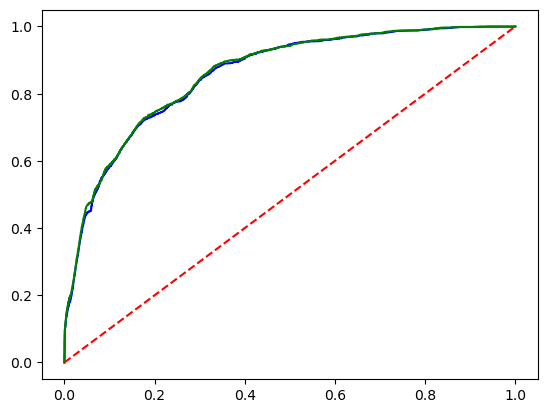

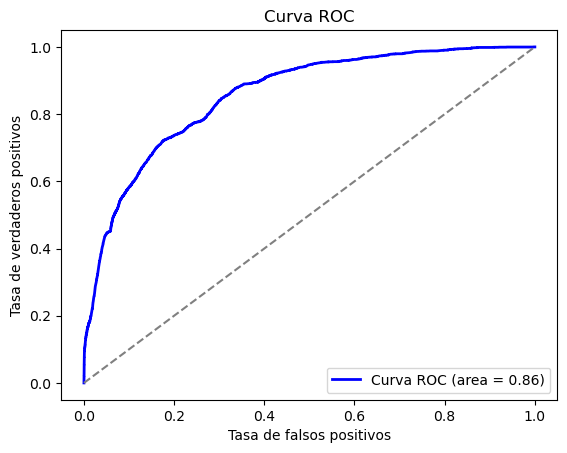

Área bajo la curva ROC para el modelo original: 0.8567
Área bajo la curva ROC para el modelo balanceado con SMOTE: 0.8594


In [266]:


# Entrenamos el modelo con los datos balanceados
modelo_bal = LogisticRegression(max_iter=200)
modelo_bal.fit(X_train_bal, y_train_bal)

# Predicciones de probabilidades para ambos modelos
y_probs = logreg.predict_proba(X_test.loc[:, rfe.support_])[:, 1]  # Modelo original
y_probs_bal = modelo_bal.predict_proba(X_test)[:, 1]  # Modelo balanceado

# Calcular curvas ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)  # Modelo original
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test, y_probs_bal)  # Modelo balanceado

# Calcular AUC
roc_auc = auc(fpr, tpr)
roc_auc_bal = auc(fpr_bal, tpr_bal)

# Graficar la curva ROC
plt.figure() # rm edit - quite fig size para hacerlos lo mismo tamaño
plt.plot(fpr, tpr, color='blue', label=f'Modelo original AUC = {roc_auc:.2f}')
plt.plot(fpr_bal, tpr_bal, color='green', label=f'Modelo con SMOTE AUC = {roc_auc_bal:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal (sin discriminación)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr_list[0], tpr_list[0], color='blue', lw=2, label='Curva ROC (area = %0.2f)' % auc(fpr_list[0], tpr_list[0]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


# Imprimir el AUC
print(f"Área bajo la curva ROC para el modelo original: {roc_auc:.4f}")
print(f"Área bajo la curva ROC para el modelo balanceado con SMOTE: {roc_auc_bal:.4f}")



### Calcular área abajo de la curva

In [268]:
# Calcular el AUC para el modelo original
roc_auc = roc_auc_score(y_test, y_probs)
print(f"Área bajo la curva ROC para el modelo original: {roc_auc:.4f}")

# Calcular el AUC para el modelo balanceado con SMOTE
roc_auc_bal = roc_auc_score(y_test, y_probs_bal)
print(f"Área bajo la curva ROC para el modelo balanceado con SMOTE: {roc_auc_bal:.4f}")


Área bajo la curva ROC para el modelo original: 0.8567
Área bajo la curva ROC para el modelo balanceado con SMOTE: 0.8594


## Grafico de la importancia de las variables. 

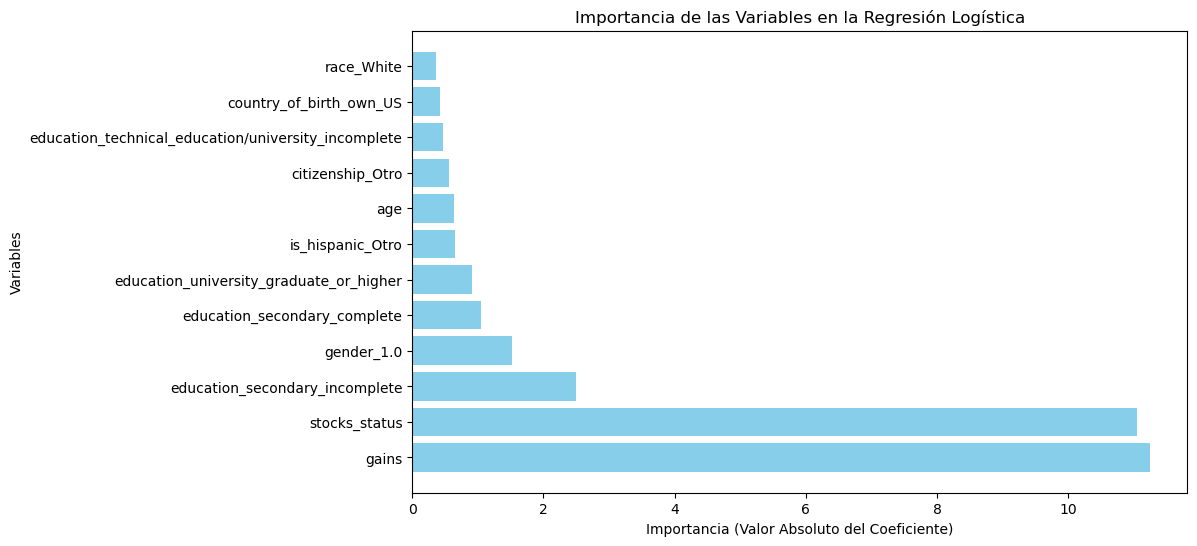

In [330]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Obtener los coeficientes del modelo entrenado
coeficientes = logreg.coef_[0]  # Coeficientes de la regresión logística

# Obtener los nombres de las variables seleccionadas por RFE
variables = X_test.loc[:, rfe.support_].columns

# Crear un DataFrame con las variables y sus coeficientes
importance_df = pd.DataFrame({
    'Variable': variables,
    'Coeficiente': coeficientes
})

# Ordenar por la magnitud del coeficiente (importancia)
importance_df['Importancia'] = importance_df['Coeficiente'].abs()
importance_df = importance_df.sort_values(by='Importancia', ascending=True)

# Graficar la importancia de las variables
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Variable'], importance_df['Importancia'], color='skyblue')
plt.xlabel('Importancia (Valor Absoluto del Coeficiente)')
plt.ylabel('Variables')
plt.title('Importancia de las Variables en la Regresión Logística')
plt.gca().invert_yaxis()  # Invertir eje Y para mostrar la variable más importante arriba
plt.show()


## Conclusiones de la grafica de importancia de nuestras variables

1. Las variables más influyentes en el modelo
Según la gráfica, las variables más importantes en la predicción son "gains", "stocks_status" y "education_secondary_incomplete", ya que presentan los coeficientes más altos en términos absolutos. Esto sugiere que los ingresos de capital y la situación con acciones tienen un fuerte impacto en la predicción del ingreso anual, junto con el nivel educativo.
2. Menor impacto de ciertas variables
Algunas variables, como "race_White", "country_of_birth_own_US", y "education_technical_education/university_incomplete", tienen coeficientes mucho más bajos, lo que indica que su contribución al modelo es mínima. Esto sugiere que, en esta regresión logística, factores como el país de nacimiento o la raza pueden no ser determinantes significativos para la predicción del ingreso anual.

# Conclusiones Finales  

1. Mejora marginal con el modelo balanceado
El área bajo la curva (AUC) para el modelo original es 0.8567, mientras que el modelo balanceado con SMOTE tiene un AUC de 0.8594. Aunque la mejora es pequeña (aproximadamente 0.003), indica que el balanceo de las clases con SMOTE ha permitido mejorar ligeramente el rendimiento del modelo en términos de su capacidad para discriminar entre clases.
2. Desempeño consistente entre ambos modelos
Aunque el modelo balanceado presenta una ligera mejora en el AUC, la diferencia no es lo suficientemente significativa como para indicar una mejora sustancial en su rendimiento. Esto sugiere que el modelo original ya estaba desempeñándose bastante bien y que el balanceo con SMOTE no generó un cambio drástico en su capacidad para clasificar correctamente los ejemplos.
3. Curvas ROC similares
Las curvas ROC de ambos modelos (original y balanceado) presentan una forma similar, con una leve inclinación hacia el eje de los verdaderos positivos, lo que sugiere que ambos modelos están haciendo un buen trabajo separando las clases. Sin embargo, el modelo balanceado tiene un AUC ligeramente superior, lo que podría indicar una mayor capacidad para identificar correctamente los positivos y minimizar los falsos positivos.
